# Simple Keras tutorial

Inspired by [elitedatascience.com](https://elitedatascience.com/keras-tutorial-deep-learning-in-python)

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Imports

In [2]:
import numpy as np

np.random.seed(123)  # for reproducibility

In [3]:
from tensorflow.keras.layers import (Activation, Convolution2D, Dense, Dropout,
                                     Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline

# Obtain mnist data

In [5]:
from tensorflow.keras.datasets import mnist

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

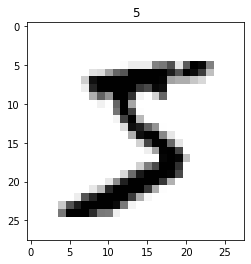

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.title((y_train[0]))
plt.show();

# Reshape data (for tensorflow)

In [8]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

# Preprocess class labels for Keras

In [10]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

In [11]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

# Define model architecture

In [12]:
# define model
model = Sequential()

# declare input layer
model.add(Convolution2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))

# add more layers
model.add(Convolution2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# and even more layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

# Compile model

In [14]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model

In [15]:
%%time
model.fit(X_train, Y_train, epochs=4, batch_size=32, verbose=1)

Epoch 1/4
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2148 - accuracy: 0.9347
Epoch 2/4
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0867 - accuracy: 0.9741
Epoch 3/4
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0682 - accuracy: 0.9795
Epoch 4/4
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0563 - accuracy: 0.9821
CPU times: user 21min 2s, sys: 37.1 s, total: 21min 39s
Wall time: 2min 51s


In [16]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))


accuracy: 99.16%


# Make some predictions

In [17]:
# calculate predictions
predictions = model.predict(X_test[:5])
output = [np.argmax(x) for x in predictions]

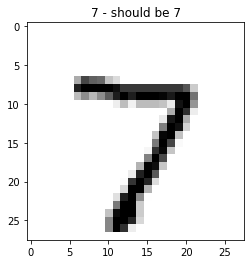

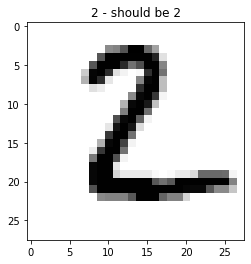

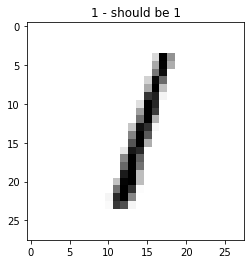

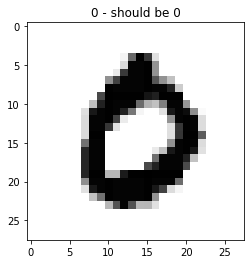

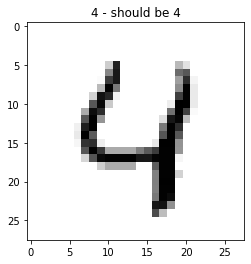

In [18]:
for i in range(5):
    plt.imshow(X_test[i, :, :, 0], cmap="binary")
    plt.title("{} - should be {}".format(output[i], np.argmax(Y_test[i])))
    plt.show()

# Save model

In [19]:
model.save("models_repository/mnist/1/model.savedmodel")

INFO:tensorflow:Assets written to: models_repository/mnist/1/model.savedmodel/assets


In [20]:
model.save("triton-models/mnist-model/mnist/1/model.savedmodel")

INFO:tensorflow:Assets written to: triton-models/mnist-model/mnist/1/model.savedmodel/assets


In [21]:
!tree triton-models/

triton-models/
└── mnist-model
    └── mnist
        └── 1
            └── model.savedmodel
                ├── assets
                ├── keras_metadata.pb
                ├── saved_model.pb
                └── variables
                    ├── variables.data-00000-of-00001
                    └── variables.index

6 directories, 4 files


In [22]:
import mlflow

In [23]:
!rm mlflow_models/ triton-mlflow/ -rf

## mlflow save model

In [24]:
mlflow.keras.save_model(model, "mlflow_models/mnist", save_format="tf")

INFO:tensorflow:Assets written to: /home/rskolasinski/work/seldon-core/examples/mnist_triton_e2e/mlflow_models/mnist/data/model/assets


In [43]:
!mkdir -p triton-mlflow/mnist-save-model/mnist/1/model.savedmodel/
!cp -r mlflow_models/mnist/data/model/* triton-mlflow/mnist-save-model/mnist/1/model.savedmodel/

In [44]:
!tree mlflow_models/

mlflow_models/
└── mnist
    ├── conda.yaml
    ├── data
    │   ├── keras_module.txt
    │   ├── model
    │   │   ├── assets
    │   │   ├── keras_metadata.pb
    │   │   ├── saved_model.pb
    │   │   └── variables
    │   │       ├── variables.data-00000-of-00001
    │   │       └── variables.index
    │   └── save_format.txt
    ├── MLmodel
    └── requirements.txt

5 directories, 9 files


In [45]:
!tree triton-mlflow/

triton-mlflow/
├── mnist-log-model
│   ├── config.pbtxt
│   └── mnist
│       ├── 1
│       │   └── model.savedmodel
│       │       ├── assets
│       │       ├── keras_metadata.pb
│       │       ├── model
│       │       │   ├── assets
│       │       │   ├── keras_metadata.pb
│       │       │   ├── saved_model.pb
│       │       │   └── variables
│       │       │       ├── variables.data-00000-of-00001
│       │       │       └── variables.index
│       │       ├── saved_model.pb
│       │       └── variables
│       │           ├── variables.data-00000-of-00001
│       │           └── variables.index
│       └── config.pbtxt
└── mnist-save-model
    ├── config.pbtxt
    └── mnist
        ├── 1
        │   └── model.savedmodel
        │       ├── assets
        │       ├── keras_metadata.pb
        │       ├── model
        │       │   ├── assets
        │       │   ├── keras_metadata.pb
        │       │   ├── saved_model.pb
        │       │   └── variables
        │       │   

## mlflow log model

In [46]:
mlflow.keras.log_model(model, "mnist", save_format="tf")

INFO:tensorflow:Assets written to: /tmp/tmpz0i5v5gj/model/data/model/assets


In [47]:
!tree mlruns

mlruns
└── 0
    ├── 5b26c1bcda4a4042915e51de6c2cb027
    │   ├── artifacts
    │   │   └── mnist
    │   │       ├── conda.yaml
    │   │       ├── data
    │   │       │   ├── keras_module.txt
    │   │       │   ├── model
    │   │       │   │   ├── assets
    │   │       │   │   ├── keras_metadata.pb
    │   │       │   │   ├── saved_model.pb
    │   │       │   │   └── variables
    │   │       │   │       ├── variables.data-00000-of-00001
    │   │       │   │       └── variables.index
    │   │       │   └── save_format.txt
    │   │       ├── MLmodel
    │   │       └── requirements.txt
    │   ├── meta.yaml
    │   ├── metrics
    │   ├── params
    │   └── tags
    │       ├── mlflow.log-model.history
    │       ├── mlflow.source.name
    │       ├── mlflow.source.type
    │       └── mlflow.user
    └── meta.yaml

11 directories, 15 files


In [2]:
!mkdir -p triton-mlflow/mnist-log-model/mnist/1/model.savedmodel/
!cp -r mlruns/0/5b26c1bcda4a4042915e51de6c2cb027/artifacts/mnist/data/model/* triton-mlflow/mnist-log-model/mnist/1/model.savedmodel/

In [4]:
!tree triton-mlflow/

triton-mlflow/
├── mnist-log-model
│   └── mnist
│       ├── 1
│       │   └── model.savedmodel
│       │       ├── assets
│       │       ├── keras_metadata.pb
│       │       ├── saved_model.pb
│       │       └── variables
│       │           ├── variables.data-00000-of-00001
│       │           └── variables.index
│       └── config.pbtxt
└── mnist-save-model
    └── mnist
        ├── 1
        │   └── model.savedmodel
        │       ├── assets
        │       ├── keras_metadata.pb
        │       ├── model
        │       │   ├── assets
        │       │   ├── keras_metadata.pb
        │       │   ├── saved_model.pb
        │       │   └── variables
        │       │       ├── variables.data-00000-of-00001
        │       │       └── variables.index
        │       ├── saved_model.pb
        │       └── variables
        │           ├── variables.data-00000-of-00001
        │           └── variables.index
        └── config.pbtxt

15 directories, 14 files
